# Analysis Code & Figures #

#### Impact of Mean Reversion of Volatility ####

$dv_t = \kappa(\theta - v_t)dt + \sigma\sqrt{v_t} W_t^v$

* $\kappa$ = speed of mean reversion
* $\theta$ = long-term mean of variance
* $\sigma$ = volatility of volatility 
* $v_t$ = instantaneous variance 
* $W_t^v$ =  Brownian-motion driving process of $v_t$
    * $W_t^v$ $\sim$ $\mathcal{N}(0,1)$ under risk neutral assumption
    * $W_t^v$ corelated to $W_t^S$ with correlation $\rho$




$\kappa(\theta - v_t)$
pulls $v_t$ towards long-term vaiariance mean $\theta$
rate is determined by $\kappa$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for high and low kappa
params = [
    {"kappa": 5.0, "label": "High kappa (5.0)"},  # Fast mean reversion
    {"kappa": 0.5, "label": "Low kappa (0.5)"}   # Slow mean reversion
]

# Common parameters
theta = 0.5       # Long-term variance
sigma = 0.3        # Volatility of variance
v0 = 0.5          # Initial variance
T = 3          # Time to maturity (1 year)
dt = 0.05         # Time step
n_steps = int(T / dt)
n_paths = 5       # Number of simulated paths



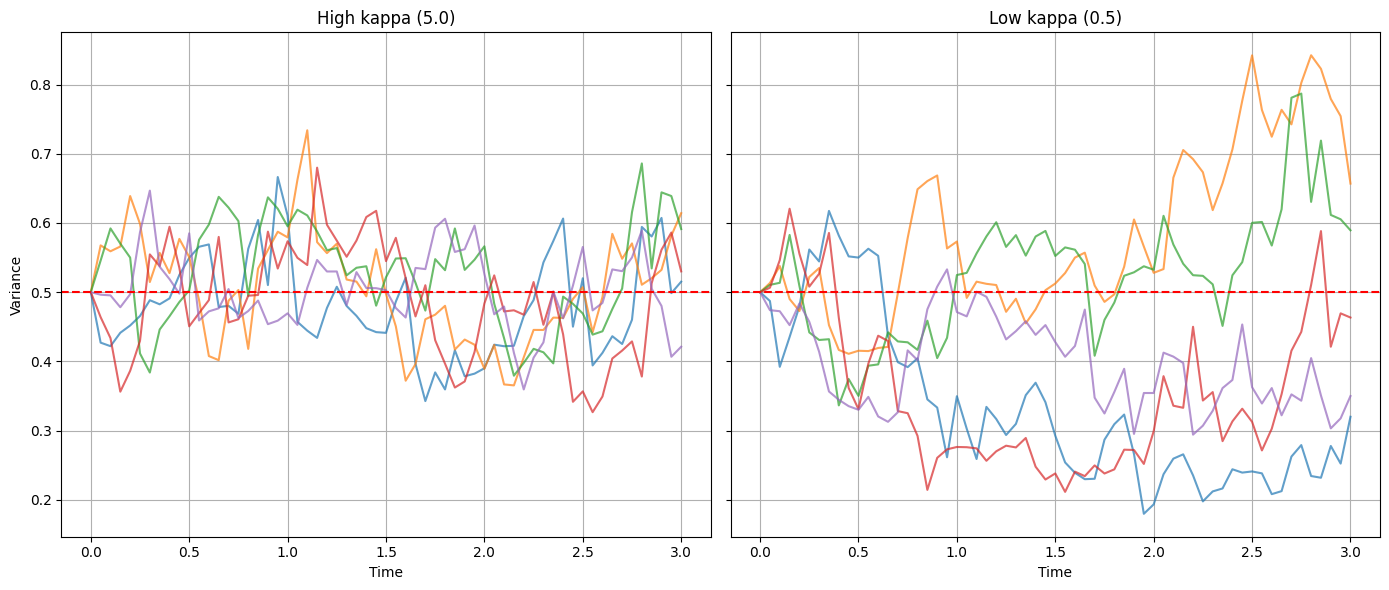

In [2]:
# Initialize plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Simulation for each kappa value
for i, param in enumerate(params):
    kappa = param["kappa"]
    variance_paths = np.zeros((n_paths, n_steps + 1))
    variance_paths[:, 0] = v0

    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)  # Random normal shocks
        v_t = variance_paths[:, t - 1]
        dv_t = kappa * (theta - v_t) * dt + sigma * np.sqrt(np.maximum(v_t, 0)) * np.sqrt(dt) * Z
        variance_paths[:, t] = v_t + dv_t

    # Plot results
    time = np.linspace(0, T, n_steps + 1)
    for j in range(n_paths):
        axes[i].plot(time, variance_paths[j, :], alpha=0.7)
    axes[i].set_title(param["label"])
    axes[i].axhline(y=theta, color='red', linestyle='--', label='Mean (theta)')
    axes[i].set_xlabel("Time")
    axes[i].grid()

axes[0].set_ylabel("Variance")
plt.tight_layout()
plt.show()

In [3]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, r, T, N, M):
    """
    Simulates the Heston stochastic volatility model under risk-neutral measure.

    Parameters:
        S0 (float): Initial asset price.
        v0 (float): Initial variance.
        rho (float): Correlation between asset returns and variance.
        kappa (float): Mean-reversion rate of variance.
        theta (float): Long-term variance (mean of variance process).
        sigma (float): Volatility of variance.
        r (float): Risk-free rate.
        T (float): Time to maturity.
        N (int): Number of time steps.
        M (int): Number of paths.

    Returns:
        S (ndarray): Simulated asset prices (shape: [N+1, M]).
        v (ndarray): Simulated variances (shape: [N+1, M]).
    """
    # Time step
    dt = T / N

    # Initialize arrays for asset prices and variance
    S = np.full((N + 1, M), S0)
    v = np.full((N + 1, M), v0)

    # Mean and covariance for correlated Brownian motions
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])

    # Generate correlated Brownian motions
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    # Simulate the Heston model
    for i in range(1, N + 1):
        Z_S = Z[i - 1, :, 0]
        Z_v = Z[i - 1, :, 1]
        
        # Update variance
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(np.maximum(v[i - 1], 0) * dt) * Z_v, 0)
        
        # Update asset price
        S[i] = S[i - 1] * np.exp((r - 0.5 * v[i - 1]) * dt + np.sqrt(np.maximum(v[i - 1], 0) * dt) * Z_S)

    return S, v


In [4]:
# estimating asset price when kappa = 5
S0 = 100.0             # asset price             # time in years
r = 0.02               # risk-free rate
N = 100                # number of time steps in simulation
M = 10
kappa_h = 10         # rate of mean reversion of variance under risk-neutral dynamics
kappa_l = 0.05        # slower rate of mean reversion of variance under risk nreutral dynamcis      # long-term mean of variance under risk-neutral dynamics        # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
theta = 0.5       # Long-term variance
sigma = 0.3        # Volatility of variance
v0 = 0.005     # Initial variance
T = 3          # Time to maturity (1 year)
dt = 0.05         # Time step
n_steps = int(T / dt)
n_paths = 5  

high_k,v_high_k = heston_model_sim(S0, v0, rho, kappa_h, theta,r, sigma,T, N, M)
low_k,v_low_k = heston_model_sim(S0, v0, rho, kappa_l, theta,r, sigma,T, N, M)

Text(0, 0.5, 'Asset Prices')

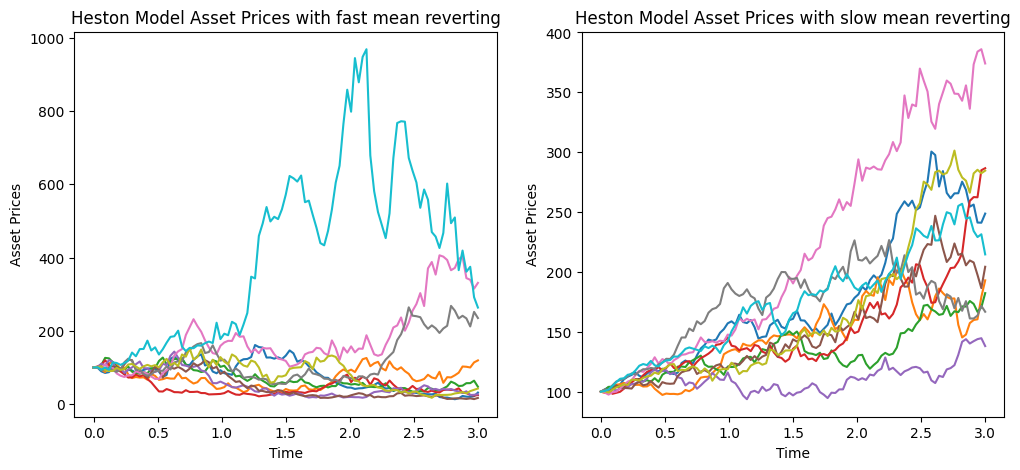

In [5]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)

ax1.plot(time,high_k)
ax1.set_title('Heston Model Asset Prices with fast mean reverting')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,low_k)
ax2.set_title('Heston Model Asset Prices with slow mean reverting')
ax2.set_xlabel('Time')
ax2.set_ylabel('Asset Prices')

In [6]:
import ace_tools as tools

fast_stats = compute_summary_statistics(high_k)
slow_stats = compute_summary_statistics(low_k)

# Combine results for comparison
summary_df = pd.DataFrame({
    "Fast Mean-Reversion": fast_stats,
    "Slow Mean-Reversion": slow_stats
})

tools.display_dataframe_to_user(name="Heston Model Summary Statistics", dataframe=summary_df)

ModuleNotFoundError: No module named 'ace_tools'